In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[ONLINE_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,3578.2700,Canada
1,2011-05-31,3399.9900,France
2,2011-05-31,3399.9900,Northwest
3,2011-05-31,699.0982,Southwest
4,2011-05-31,3399.9900,Australia


In [6]:
dataset.shape

(60398, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 3 columns):
OrderDate         60398 non-null datetime64[ns]
Revenue           60398 non-null float64
Territory_Name    60398 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


In [8]:
dataset.groupby("Territory_Name").size()

Territory_Name
Australia         13345
Canada             7620
Central              20
France             5558
Germany            5625
Northeast            27
Northwest          8993
Southeast            39
Southwest         12265
United Kingdom     6906
dtype: int64

## Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [106]:
CA = dataset.loc[dataset['Territory_Name'] == 'Canada']
NE = dataset.loc[dataset['Territory_Name'] == 'Northeast']
NW = dataset.loc[dataset['Territory_Name'] == 'Northwest']
CA.shape, NE.shape, NW.shape

((7620, 3), (27, 3), (8993, 3))

In [107]:
CA['OrderDate'] =  pd.to_datetime(CA['OrderDate'], format='%Y/%m')
CA = CA.sort_values(by=['OrderDate'], ascending=[True])
CA.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

NE['OrderDate'] =  pd.to_datetime(NE['OrderDate'], format='%Y/%m')
NE = NE.sort_values(by=['OrderDate'], ascending=[True])
NE.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

NW['OrderDate'] =  pd.to_datetime(NW['OrderDate'], format='%Y/%m')
NW = NW.sort_values(by=['OrderDate'], ascending=[True])
NW.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

CA.drop(["Territory_Name"],axis=1, inplace=True)
NE.drop(["Territory_Name"],axis=1, inplace=True)
NW.drop(["Territory_Name"],axis=1, inplace=True)

In [108]:
#y = df.resample('MS').mean()
y_CA = CA.resample('MS').sum()
y_NE = NE.resample('MS').sum()
z_NW = NW.resample('MS').sum()

In [109]:
# filling up by mean value
y_CA = y_CA['Revenue'].replace(0.000000, y_CA['Revenue'].mean())
y_NE = y_NE['Revenue'].replace(0.000000, y_NE['Revenue'].mean())
z_NW = z_NW['Revenue'].replace(0.000000, z_NW['Revenue'].mean())

In [110]:
CA = pd.DataFrame({'OrderDate': y_CA.index, 'Revenue': y_CA.values})
NE = pd.DataFrame({'OrderDate': y_NE.index, 'Revenue': y_NE.values})
NW = pd.DataFrame({'OrderDate': z_NW.index, 'Revenue': z_NW.values})

In [111]:
store = CA.merge(NW,how='inner', on='OrderDate')
store.rename(columns={'Revenue_x': 'CA_revenue', 'Revenue_y': 'NW_revenue'}, inplace=True)
store.head()

,OrderDate,CA_revenue,NW_revenue
0,2011-05-01,3578.2700,3399.9900
1,2011-06-01,18387.1682,55186.5046
2,2011-07-01,28918.6982,43955.8764
3,2011-08-01,17891.3500,50235.0382
4,2011-09-01,11929.7264,58968.0546


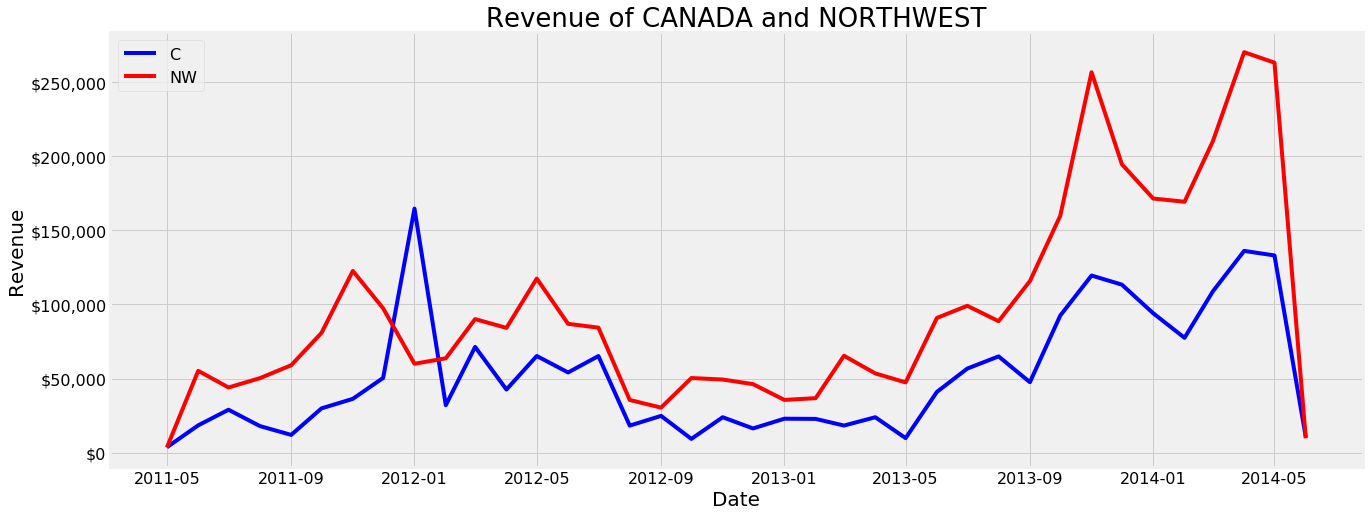

In [112]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['CA_revenue'], 'b-', label = 'C')
plt.plot(store['OrderDate'], store['NW_revenue'], 'r-', label = 'NW')
plt.xlabel('Date'); 
plt.ylabel('Revenue'); 
plt.title('Revenue of CANADA and NORTHWEST')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.legend();

# Fitt Model with Prophet

In [114]:
from fbprophet import Prophet
CA = CA.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
CA_model = Prophet(interval_width=0.95)
CA_model.fit(CA)

NE = NE.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
NE_model = Prophet(interval_width=0.95)
NE_model.fit(NE)

NW = NW.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
NW_model = Prophet(interval_width=0.95)
NW_model.fit(NW)

CA_forecast = CA_model.make_future_dataframe(periods=60, freq='MS')
CA_forecast = CA_model.predict(CA_forecast)

NE_forecast = NE_model.make_future_dataframe(periods=60, freq='MS')
NE_forecast = NE_model.predict(NE_forecast)

NW_forecast = NW_model.make_future_dataframe(periods=60, freq='MS')
NW_forecast = NW_model.predict(NW_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 2016x864 with 0 Axes>

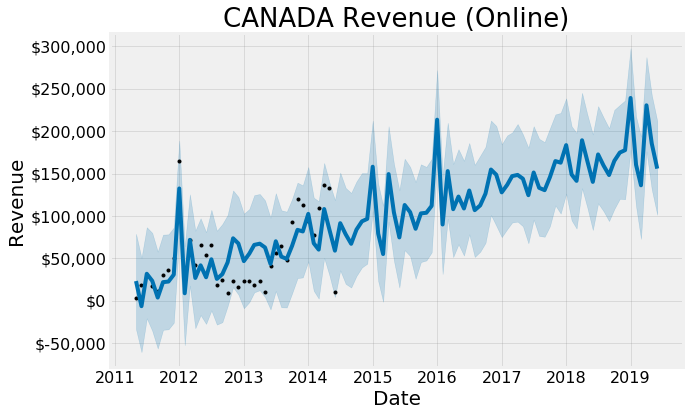

In [115]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
CA_model.plot(CA_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CANADA Revenue (Online)');

<Figure size 2016x864 with 0 Axes>

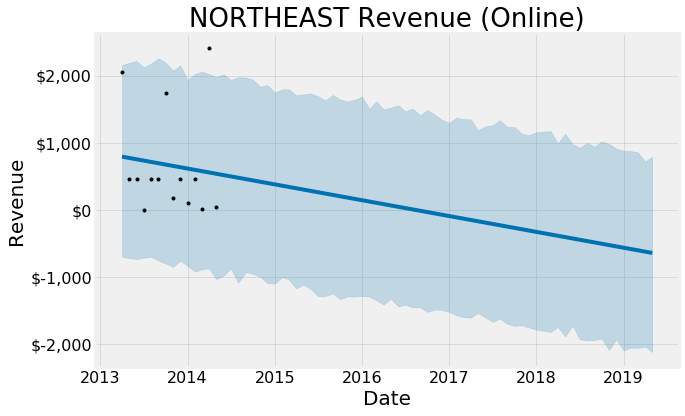

In [116]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
NE_model.plot(NE_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('NORTHEAST Revenue (Online)');

<Figure size 2016x864 with 0 Axes>

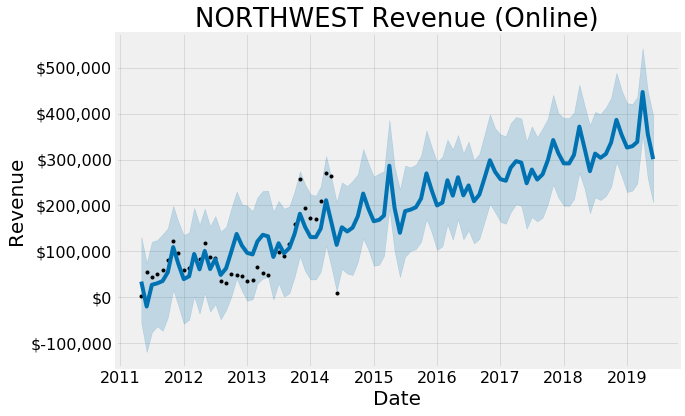

In [117]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
NW_model.plot(NW_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('NORTHWEST Revenue (Online)');

# Compare Forecasts
We already have the forecasts for three years for these two Teritory into the future. We will now join them together to compare their future forecasts.

In [118]:
CA_names = ['CA_%s' % column for column in CA_forecast.columns]
NE_names = ['NE_%s' % column for column in NE_forecast.columns]
NW_names = ['NW_%s' % column for column in NW_forecast.columns]

merge_CA_forecast = CA_forecast.copy()
merge_NE_forecast = NE_forecast.copy()
merge_NW_forecast = NW_forecast.copy()

merge_CA_forecast.columns = CA_names
merge_NE_forecast.columns = NE_names
merge_NW_forecast.columns = NW_names


forecast = pd.merge(merge_CA_forecast, merge_NW_forecast, how = 'inner', left_on = 'CA_ds', right_on = 'NW_ds')
forecast = forecast.rename(columns={'CA_ds': 'Date'}).drop('NW_ds', axis=1)
forecast.head()

,Date,CA_trend,CA_yhat_lower,CA_yhat_upper,CA_trend_lower,CA_trend_upper,CA_additive_terms,CA_additive_terms_lower,CA_additive_terms_upper,CA_yearly,...,NW_additive_terms,NW_additive_terms_lower,NW_additive_terms_upper,NW_yearly,NW_yearly_lower,NW_yearly_upper,NW_multiplicative_terms,NW_multiplicative_terms_lower,NW_multiplicative_terms_upper,NW_yhat
0,2011-05-01,27785.063583,-33559.970066,78898.890933,27785.063583,27785.063583,-4573.654971,-4573.654971,-4573.654971,-4573.654971,...,-4586.699793,-4586.699793,-4586.699793,-4586.699793,-4586.699793,-4586.699793,0.0,0.0,0.0,34060.294244
1,2011-06-01,29505.117367,-60533.826388,50506.774625,29505.117367,29505.117367,-35892.720032,-35892.720032,-35892.720032,-35892.720032,...,-62361.241460,-62361.241460,-62361.241460,-62361.241460,-62361.241460,-62361.241460,0.0,0.0,0.0,-20306.938539
2,2011-07-01,31169.685541,-20699.227557,86651.330622,31169.685541,31169.685541,630.017104,630.017104,630.017104,630.017104,...,-18325.443384,-18325.443384,-18325.443384,-18325.443384,-18325.443384,-18325.443384,0.0,0.0,0.0,27026.255234
3,2011-08-01,32889.739318,-35416.848243,79940.461143,32889.739318,32889.739318,-9471.497679,-9471.497679,-9471.497679,-9471.497679,...,-18473.363076,-18473.363076,-18473.363076,-18473.363076,-18473.363076,-18473.363076,0.0,0.0,0.0,30285.644434
4,2011-09-01,34609.793094,-56266.133514,57921.797484,34609.793094,34609.793094,-30841.655490,-30841.655490,-30841.655490,-30841.655490,...,-16868.824960,-16868.824960,-16868.824960,-16868.824960,-16868.824960,-16868.824960,0.0,0.0,0.0,35297.491439


# Trend and Forecast Visualization

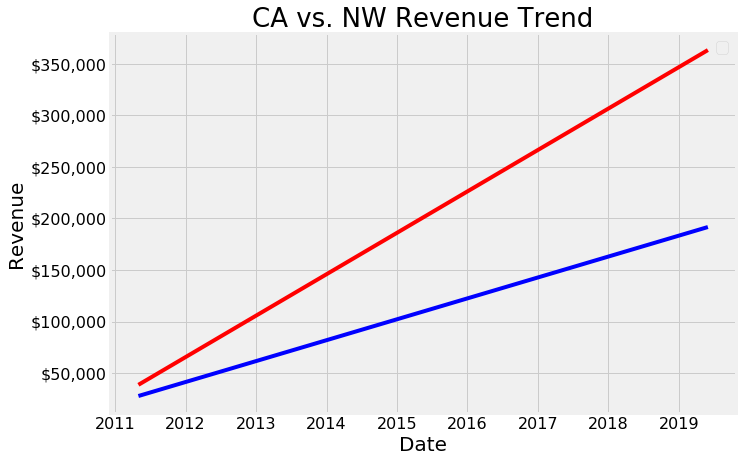

In [119]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['CA_trend'], 'b-')
plt.plot(forecast['Date'], forecast['NW_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CA vs. NW Revenue Trend');

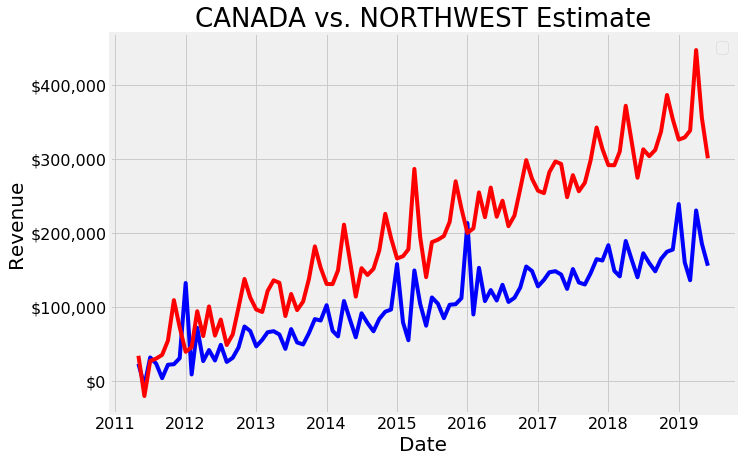

In [120]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['CA_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['NW_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CANADA vs. NORTHWEST Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

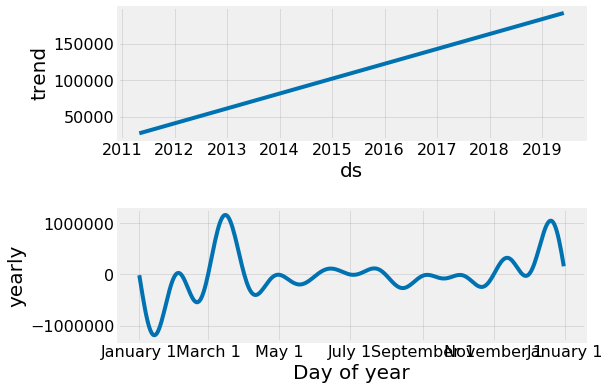

In [121]:
CA_model.plot_components(CA_forecast);

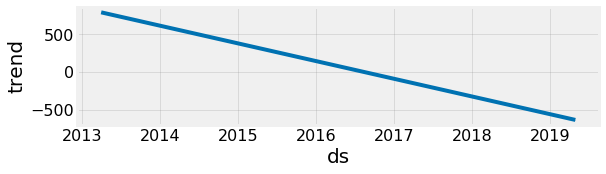

In [122]:
NE_model.plot_components(NE_forecast);

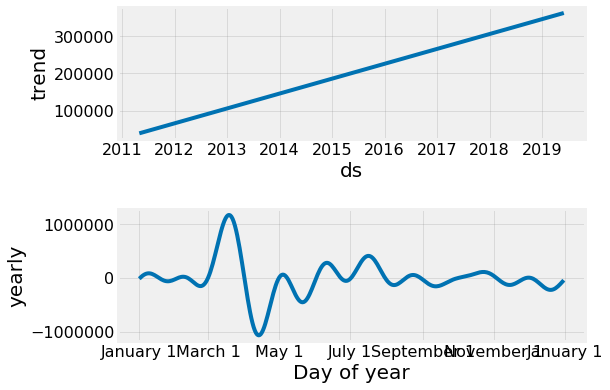

In [123]:
NW_model.plot_components(NW_forecast);

Good to see that the revenue for both CANADA and NORTHWEST have been linearly increasing over time and will be keep growing, although Southeast’ growth seems downward.
The worst month for southeasr  is October, the worst month for Southwest is November. The best month for Southeast is September, and the best month for Southwest is December.
There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.